In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import os

DATASET_PATH = "/content/drive/MyDrive/project_dataset"
print("Dataset Path:", DATASET_PATH)

Dataset Path: /content/drive/MyDrive/project_dataset


In [5]:
import os
import numpy as np
import cv2

IMG_SIZE = 128

def load_stage1_dataset(dataset_path, limit=None):

    images = []
    masks = []

    folders = os.listdir(dataset_path)

    if limit:
        folders = folders[:limit]

    for folder in folders:

        folder_path = os.path.join(dataset_path, folder)

        img_folder = os.path.join(folder_path, "images")
        mask_folder = os.path.join(folder_path, "masks")

        # Skip if folders missing
        if not os.path.exists(img_folder) or not os.path.exists(mask_folder):
            continue

        # ---- Load Image ----
        img_files = os.listdir(img_folder)
        if len(img_files) == 0:
            continue

        img_path = os.path.join(img_folder, img_files[0])

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # ---- Merge Masks ----
        merged_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        mask_files = os.listdir(mask_folder)
        if len(mask_files) == 0:
            continue

        for mask_file in mask_files:
            mask_path = os.path.join(mask_folder, mask_file)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask / 255.0

            merged_mask += mask

        merged_mask = (merged_mask > 0).astype("float32")
        merged_mask = np.expand_dims(merged_mask, axis=-1)

        images.append(img)
        masks.append(merged_mask)

    # ✅ MUST RETURN
    return np.array(images), np.array(masks)


In [6]:
X, Y = load_stage1_dataset(DATASET_PATH, limit=200)

print("Images:", X.shape)
print("Masks :", Y.shape)

Images: (200, 128, 128, 3)
Masks : (200, 128, 128, 1)


In [7]:
np.save("/content/drive/MyDrive/X.npy", X)
np.save("/content/drive/MyDrive/Y.npy", Y)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def MultiResBlock(U, inp):

    shortcut = layers.Conv2D(U, 1, padding="same")(inp)

    conv3x3 = layers.Conv2D(int(U*0.167), 3, activation="relu", padding="same")(inp)
    conv5x5 = layers.Conv2D(int(U*0.333), 3, activation="relu", padding="same")(conv3x3)
    conv7x7 = layers.Conv2D(int(U*0.5), 3, activation="relu", padding="same")(conv5x5)

    out = layers.Concatenate()([conv3x3, conv5x5, conv7x7])

    out = layers.BatchNormalization()(out)

    out = layers.Add()([shortcut, out])
    out = layers.Activation("relu")(out)

    return out


In [10]:
def ResPath(filters, length, inp):

    x = inp

    for i in range(length):

        shortcut = layers.Conv2D(filters, 1, padding="same")(x)

        x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
        x = layers.Add()([shortcut, x])
        x = layers.Activation("relu")(x)

    return x


In [13]:
def MultiResBlock(U, inp):

    # Shortcut must match output channels
    shortcut = layers.Conv2D(U, 1, padding="same")(inp)

    # Correct filter split
    f1 = int(U * 0.167)
    f2 = int(U * 0.333)
    f3 = U - (f1 + f2)   # <-- FIX: remaining channels

    conv3x3 = layers.Conv2D(f1, 3, activation="relu", padding="same")(inp)
    conv5x5 = layers.Conv2D(f2, 3, activation="relu", padding="same")(conv3x3)
    conv7x7 = layers.Conv2D(f3, 3, activation="relu", padding="same")(conv5x5)

    out = layers.Concatenate()([conv3x3, conv5x5, conv7x7])

    out = layers.BatchNormalization()(out)

    # Now shapes match: U channels
    out = layers.Add()([shortcut, out])
    out = layers.Activation("relu")(out)

    return out



In [14]:
model = MultiResUNet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │        140 │ input_layer_1[0]… │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │        460 │ conv2d_5[0][0]    │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      1,547 │ conv2d_6[0][0]    │
│                     │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 32)               │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        128 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ conv2d_4[0][0],   │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ add_1[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │      2,890 │ max_pooling2d[0]… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │      1,911 │ conv2d_17[0][0]   │
│                     │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │      6,270 │ conv2d_18[0][0]   │
│                     │ 33)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_17[0][0],  │
│ (Concatenate)       │ 64)               │            │ conv2d_18[0][0],  │
│                     │                   │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ concatenate_2[0]… │
│ (BatchNormalizatio… │ 64)               │            │                 

 Total params: 3,106,640 (11.85 MB)

 Trainable params: 3,103,696 (11.84 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [15]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [16]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10,
    batch_size=4
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7574 - loss: 0.6964 - val_accuracy: 0.8715 - val_loss: 0.5395
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9412 - loss: 0.1591 - val_accuracy: 0.8594 - val_loss: 0.3457
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9508 - loss: 0.1223 - val_accuracy: 0.9151 - val_loss: 0.3394
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.9632 - loss: 0.1019 - val_accuracy: 0.9054 - val_loss: 0.2473
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9717 - loss: 0.0789 - val_accuracy: 0.8998 - val_loss: 0.2442
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9674 - loss: 0.0895 - val_accuracy: 0.9090 - val_loss: 0.2633
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9729 - loss: 0.0733 - val_accuracy: 0.8525 - val_loss: 0.2881
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9752 - loss: 0.0663 - val_accuracy: 0.8212 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


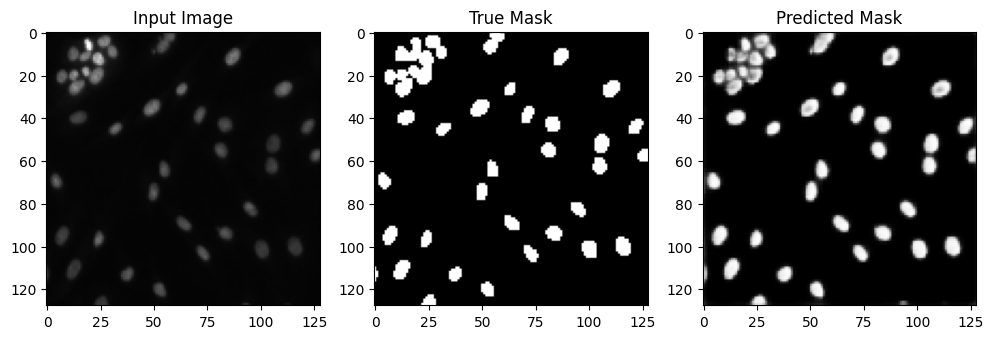

In [17]:
import matplotlib.pyplot as plt

index = 0
pred = model.predict(X_test[index:index+1])[0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(X_test[index])

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(Y_test[index].squeeze(), cmap="gray")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred.squeeze(), cmap="gray")

plt.show()


In [18]:
model.save("/content/drive/MyDrive/multiresunet_model.h5")
print("MultiResUNet Model Saved Successfully!")

MultiResUNet Model Saved Successfully!
